In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import copy
from torch.utils.data import DataLoader

# Set device
device = torch.device("mps")
print(f"Using device: {device}")

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset (will be downloaded automatically if not present)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Create ResNet50 model
def create_resnet50(num_classes=10):
    # Load pre-trained ResNet50
    model = models.resnet50(weights='IMAGENET1K_V1')

    # Modify the first conv layer to accept 3-channel 32x32 inputs
    # ResNet was designed for 224x224 images, but CIFAR-10 images are 32x32
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool as we're using small images

    # Modify the final FC layer to output 10 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (track history if only in train)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.float() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Create model and move to device
model = create_resnet50(num_classes=10)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Create dataloaders dictionary
dataloaders = {
    'train': trainloader,
    'val': testloader
}

# # Train model
# model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
#
# # Save the trained model
# torch.save(model.state_dict(), 'checkpoints/resnet50_cifar10.pth')

state_dict = torch.load('checkpoints/resnet50_cifar10.pth')
# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Evaluate model on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final accuracy on test set: {100 * correct / total:.2f}%')

# Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

Using device: mps
Final accuracy on test set: 94.50%
Accuracy of plane: 94.50%
Accuracy of car: 98.80%
Accuracy of bird: 94.10%
Accuracy of cat: 87.50%
Accuracy of deer: 94.30%
Accuracy of dog: 92.00%
Accuracy of frog: 97.70%
Accuracy of horse: 95.00%
Accuracy of ship: 96.30%
Accuracy of truck: 94.80%


In [2]:
test_set = list(testloader)
xs, ys = test_set[0] # batch 0
print(xs.shape, ys.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


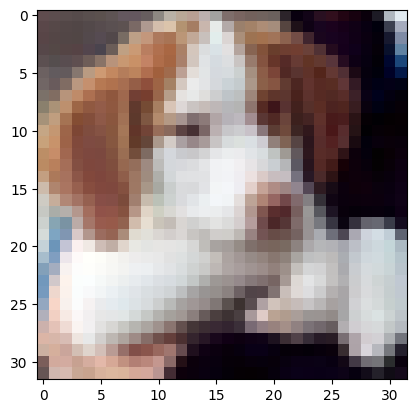

In [3]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)  # Reshape for broadcasting
    std = torch.tensor(std).view(3, 1, 1).to(device)
    return tensor * std + mean  # Reverse the normalization

def toImage(tensor):
    unormal = unnormalize(tensor, (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    to_pil = ToPILImage()
    return to_pil(unormal)

# Convert to PIL Image
x, y = xs[16].to(device), ys[16].to(device)
plt.imshow(toImage(x))

In [4]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
# Make x batched and trainable
x = x.view(-1, *x.shape)
x.requires_grad = True

In [5]:
# Get the gradient of the loss with respect to the input image
y_pred = model(x)

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(y_pred, y.view(1))  # cross entropy loss
loss += 0.01 * torch.sum(x ** 2)  # L2 loss

x.grad = None
loss.backward()
print(x.grad)

tensor([[[[-0.0096, -0.0106, -0.0115,  ..., -0.0303,  0.0158,  0.0317],
          [-0.0112, -0.0125, -0.0134,  ..., -0.0398, -0.0207,  0.0126],
          [-0.0118, -0.0131, -0.0137,  ..., -0.0382, -0.0322,  0.0005],
          ...,
          [ 0.0247,  0.0279,  0.0243,  ...,  0.0180, -0.0023, -0.0280],
          [-0.0007,  0.0269,  0.0272,  ..., -0.0030, -0.0258, -0.0363],
          [-0.0074,  0.0262,  0.0285,  ..., -0.0280, -0.0344, -0.0328]],

         [[-0.0152, -0.0148, -0.0148,  ..., -0.0306,  0.0193,  0.0358],
          [-0.0168, -0.0164, -0.0167,  ..., -0.0396, -0.0193,  0.0155],
          [-0.0174, -0.0171, -0.0171,  ..., -0.0396, -0.0312,  0.0052],
          ...,
          [ 0.0171,  0.0168,  0.0135,  ...,  0.0193, -0.0010, -0.0293],
          [-0.0093,  0.0152,  0.0155,  ..., -0.0022, -0.0251, -0.0386],
          [-0.0122,  0.0193,  0.0203,  ..., -0.0290, -0.0354, -0.0361]],

         [[-0.0108, -0.0107, -0.0110,  ..., -0.0227,  0.0231,  0.0378],
          [-0.0122, -0.0125, -

tensor([[4.1899e-05, 1.7858e-06, 9.9973e-01, 6.1897e-05, 3.9807e-05, 1.4603e-05,
         9.6567e-05, 3.2505e-06, 8.3403e-06, 6.5564e-06]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


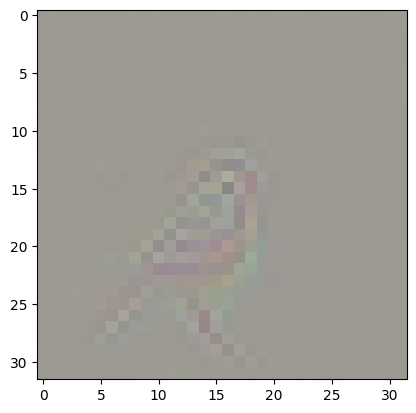

In [6]:
# Update the image in a loop
x = torch.randn((1, 3, 32, 32), device=device)
y = torch.tensor([2], device=device) # bird

x.requires_grad = True
for i in range(250):
    y_pred = model(x)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(y_pred, y.view(1))  # cross entropy loss
    loss += 0.01 * torch.sum(x ** 2)  # L2 loss

    x.grad = None
    loss.backward()
    x.data -= 5 * x.grad

print(F.softmax(model(x), dim=1))
plt.imshow(toImage(5.0 * x.squeeze(0) + 0.5))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Dropdown, Output
from IPython.display import display, clear_output

# Assuming you have your model, xs, ys, toImage function already defined

def generate_adversarial_image(target_class=None, steps=100,
                               learning_rate=5.0, scaling_factor=0.6, shift=0.0,
                               use_l2_reg=False, reg_strength=0.01, noise_init=False):
    x = torch.randn((1, 3, 32, 32), device=device)
    y = torch.tensor([target_class], device=device)

    # Initialize with zeros or random noise
    if noise_init:
        x_adv = torch.randn_like(x) * 0.1
    else:
        x_adv = torch.zeros_like(x)

    x_adv.requires_grad = True

    # Create a figure for displaying the image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Store the loss values for plotting
    loss_values = []
    prob_values = []

    # Create an output widget for status updates
    out = Output()
    display(out)

    for i in range(steps):
        y_pred = model(x_adv)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(y_pred, y.view(1))

        # Add L2 regularization if enabled
        if use_l2_reg:
            l2_loss = reg_strength * torch.sum(x_adv ** 2)
            loss = loss + l2_loss

        loss_values.append(loss.item())

        # Calculate current probability of target class
        probs = F.softmax(y_pred, dim=1)
        target_prob = probs[0, y.item()].item()
        prob_values.append(target_prob)

        x_adv.grad = None
        loss.backward()
        x_adv.data -= learning_rate * x_adv.grad

        # Update the plot every 10 steps or on the last step
        if i % 10 == 0 or i == steps - 1:
            with out:
                clear_output(wait=True)

                # Plot the image with adjusted scaling and shift
                ax1.clear()
                # Apply scaling factor and shift to the image
                img_data = scaling_factor * x_adv.squeeze(0) + shift
                ax1.imshow(toImage(img_data))
                ax1.set_title(f'Generated Image (Step {i+1})')

                # Plot the loss curve and target probability
                ax2.clear()
                ax2.plot(loss_values, 'b-', label='Loss')
                ax2.set_xlabel('Iteration')
                ax2.set_ylabel('Loss', color='b')
                ax2.tick_params(axis='y', labelcolor='b')

                # Add target probability on secondary y-axis
                ax3 = ax2.twinx()
                ax3.plot(prob_values, 'r-', label='Target Probability')
                ax3.set_ylabel('Target Class Probability', color='r')
                ax3.tick_params(axis='y', labelcolor='r')
                ax3.set_ylim(0, 1)

                plt.tight_layout()
                display(fig)

                # Print status info
                print(f"Step {i+1}/{steps}: Loss = {loss.item():.4f}, Target Prob = {target_prob:.4f}")

    # Print the final class probabilities for all classes
    probs = F.softmax(model(x_adv), dim=1)

    # Get top 5 classes
    values, indices = torch.topk(probs[0], 5)

    with out:
        print("\nFinal Predictions:")
        for i, (idx, prob) in enumerate(zip(indices.cpu().detach().numpy(), values.cpu().detach().numpy())):
            print(f"  {i+1}. Class {idx}: {prob:.4f}")

    return x_adv

# Prepare class labels for the dropdown (assuming we have class names)
# If class_names isn't available, we'll use class indices
try:
    class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
    class_options = {f"{i}: {name}": i for i, name in enumerate(class_names)}
except NameError:
    num_classes = model(xs[0].unsqueeze(0).to(device)).shape[1]  # Infer from model output
    class_options = {f"Class {i}": i for i in range(num_classes)}

# Create interactive slider controls
def interactive_generation(target_class, steps, learning_rate,
                           scaling_factor, shift, use_l2_reg, reg_strength, noise_init):
    # Convert target_class from string to integer index if necessary
    if target_class in class_options:
        target_idx = class_options[target_class]
    else:
        target_idx = None

    _ = generate_adversarial_image(
        target_class=target_idx,
        steps=steps,
        learning_rate=learning_rate,
        scaling_factor=scaling_factor,
        shift=shift,
        use_l2_reg=use_l2_reg,
        reg_strength=reg_strength,
        noise_init=noise_init
    )

# Make the widget layout wider
wide_layout = Layout(width='500px')

# Create the interactive interface
class_targets = list(class_options.keys())
interact(
    interactive_generation,
    target_class=Dropdown(options=class_targets, value=class_targets[0], description='Target Class:', layout=wide_layout),
    steps=IntSlider(min=10, max=500, step=10, value=250, description='Steps:', layout=wide_layout),
    learning_rate=FloatSlider(min=0.1, max=20.0, step=0.1, value=2.5, description='Learning Rate:', layout=wide_layout),
    scaling_factor=FloatSlider(min=1, max=50.0, step=1, value=5.0, description='Scaling Factor:', layout=wide_layout),
    shift=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.5, description='Shift:', layout=wide_layout),
    use_l2_reg=Dropdown(options=[True, False], value=True, description='L2 Regularization:', layout=wide_layout),
    reg_strength=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01, description='Reg Strength:', layout=wide_layout),
    noise_init=Dropdown(options=[True, False], value=True, description='Random Init:', layout=wide_layout)
);

interactive(children=(Dropdown(description='Target Class:', layout=Layout(width='500px'), options=('0: Airplan…